# Train Various Regression Models and Compare Their Performances

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

## Part 1. Build DataFrame and Define ML Problem

#### Load a Data Set and Save it as a Pandas DataFrame

We will work with the data set ``airbnbData_train``. This data set already has all the necessary preprocessing steps implemented, including one-hot encoding of the categorical variables, scaling of all numerical variable values, and imputing missing values. It is ready for modeling.

In [2]:
filename = os.path.join(os.getcwd(), "..", "data", "airbnbData_train.csv")
df = pd.read_csv(filename)

#### Define the Label

Our goal is to train a machine learning model that predicts the price of an Airbnb listing. This is an example of supervised learning and is a regression problem. In our dataset, our label will be the `price` column and the label contains continuous values.

#### Evaluation Metrics for Regressors

So far, we have mostly focused on classification problems. For this assignment, we will focus on a regression problem and predict a continuous outcome. There are different evaluation metrics that are used to determine the performance of a regressor. We will use two metrics to evaluate our regressors: RMSE (root mean square error) and $R^2$ (coefficient of determination).

RMSE:<br>
RMSE finds the average difference between the predicted values and the actual values. We will compute the RMSE on the test set.  To compute the RMSE, we will use the scikit-learn ```mean_squared_error()``` function. Since RMSE finds the difference between the predicted and actual values, lower RMSE values indicate good performance - the model fits the data well and makes more accurate predictions. On the other hand, higher RSME values indicate that the model is not performing well.

$R^2$:<br>
$R^2$ is a measure of the proportion of variability in the prediction that the model was able to make using the test data. An $R^2$ value of 1 is perfect and 0 implies no explanatory value. We can use scikit-learn's ```r2_score()``` function to compute it. Since $R^2$ measures how well the model fits the data, a higher $R^2$ value indicates that good performance and a lower $R^2$ indicates that poor performance.

#### Identify Features

Our features will be all of the remaining columns in the dataset.

## Part 2. Create Labeled Examples from the Data Set 

In [3]:
y = df['price']
X = df.drop(columns='price')

## Part 3. Create Training and Test Data Sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)

## Part 4: Train, Test and Evaluate Two Regression Models: Linear Regression and Decision Tree

### a. Train, Test and Evaluate a Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
lr_model = LinearRegression()

In [7]:
# Call predict() to use the fitted model to make predictions on the test data
lr_model.fit(X_train, y_train)
y_lr_pred = lr_model.predict(X_test)

To compute the RMSE, we will use the scikit-learn ```mean_squared_error()``` function, which computes the mean squared error between the predicted values and the actual values: ```y_lr_pred``` and```y_test```. In order to obtain the root mean squared error, we will specify the parameter `squared=False`. 

To compute the $R^2$, we will use the scikit-learn ```r2_score()``` function. 

In [8]:
# 1. Compute the RMSE using mean_squared_error()
lr_rmse = root_mean_squared_error(y_test, y_lr_pred)

# 2. Compute the R2 score using r2_score()
lr_r2 = r2_score(y_test, y_lr_pred)

print('[LR] Root Mean Squared Error: {0}'.format(lr_rmse))
print('[LR] R2: {0}'.format(lr_r2))

[LR] Root Mean Squared Error: 0.7447285738089425
[LR] R2: 0.4746782522812476


### b. Train, Test and Evaluate a Decision Tree Using GridSearch

In [9]:
from sklearn.tree import DecisionTreeRegressor

#### Set Up a Parameter Grid 

In [10]:
param_grid = {'max_depth': [4, 8], 'min_samples_leaf': [25, 50]}

In [11]:
print('Running Grid Search...')

# 1. Create a DecisionTreeRegressor model object without supplying arguments. 
#    Save the model object to the variable 'dt_regressor'

dt_regressor = DecisionTreeRegressor()


# 2. Run a Grid Search with 3-fold cross-validation and assign the output to the object 'dt_grid'.
#    * Pass the model and the parameter grid to GridSearchCV()
#    * Set the number of folds to 3
#    * Specify the scoring method

dt_grid = GridSearchCV(dt_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')


# 3. Fit the model (use the 'grid' variable) on the training data and assign the fitted model to the 
#    variable 'dt_grid_search'

dt_grid_search = dt_grid.fit(X_train, y_train)

print('Done')


Running Grid Search...
Done


The code cell below prints the RMSE score of the best model using the `best_score_` attribute of the fitted grid search object `dt_grid_search`. Note that specifying a scoring method of `neg_root_mean_squared_error` will result in the negative RMSE, so we will multiply `dt_grid_search.best_score` by -1 to obtain the RMSE.

In [12]:
rmse_DT = -1 * dt_grid_search.best_score_
print("[DT] RMSE for the best model is : {:.2f}".format(rmse_DT) )

[DT] RMSE for the best model is : 0.72


In [13]:
dt_best_params = dt_grid_search.best_params_

dt_best_params

{'max_depth': 8, 'min_samples_leaf': 25}

In [14]:
dt_model = DecisionTreeRegressor(max_depth=dt_best_params['max_depth'], min_samples_leaf=dt_best_params['min_samples_leaf'])
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=25)

In [15]:
# 1. Use the fitted model to make predictions on the test data
y_dt_pred = dt_model.predict(X_test)

# 2. Compute the RMSE using mean_squared_error()
dt_rmse = root_mean_squared_error(y_test, y_dt_pred)

# 3. Compute the R2 score using r2_score()
dt_r2 = r2_score(y_test, y_dt_pred)

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse))
print('[DT] R2: {0}'.format(dt_r2))

[DT] Root Mean Squared Error: 0.7164562777611696
[DT] R2: 0.5138069673929249


## Part 5: Train, Test and Evaluate Ensemble Models: Stacking 

In [16]:
from sklearn.ensemble import StackingRegressor

In this part of the assignment, we will use two models jointly. In the code cell below, we creates a list of tuples, each consisting of a scikit-learn model function and the corresponding shorthand name that we choose. We will specify the hyperparameters for the decision tree that we determined through the grid search above.

In [17]:
estimators = [("DT", DecisionTreeRegressor(max_depth=dt_best_params["max_depth"], min_samples_leaf=dt_best_params["min_samples_leaf"])),
              ("LR", LinearRegression())
             ]

In [18]:
print('Implement Stacking...')

stacking_model = StackingRegressor(estimators=estimators, passthrough=False)
stacking_model.fit(X_train, y_train)

print('End')

Implement Stacking...
End


In [19]:
# 1. Use the fitted model to make predictions on the test data
stacking_pred = stacking_model.predict(X_test)

# 2. Compute the RMSE 
stack_rmse = root_mean_squared_error(y_test, stacking_pred)

# 3. Compute the R2 score
stack_r2 = r2_score(y_test, stacking_pred)
   
print('Root Mean Squared Error: {0}'.format(stack_rmse))
print('R2: {0}'.format(stack_r2))                       

Root Mean Squared Error: 0.6930261573047307
R2: 0.5450867362722301


## Part 6: Train, Test and Evaluate  Evaluate Ensemble Models: Gradient Boosted Decision Trees 

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

Let's assume we already performed a grid search to find the best model hyperparameters for our gradient boosted decision tree. (We are omitting this step to save computation time.) The best values are: `max_depth=2`, and `n_estimators = 300`. 

In [21]:
print('Begin GBDT Implementation...')

gbdt_model = GradientBoostingRegressor(max_depth=2, n_estimators=300)
gbdt_model.fit(X_train, y_train)

print('End')

Begin GBDT Implementation...
End


In [22]:
# 1. Use the fitted model to make predictions on the test data
y_gbdt_pred = gbdt_model.predict(X_test)

# 2. Compute the RMSE 
gbdt_rmse = root_mean_squared_error(y_test, y_gbdt_pred)

# 3. Compute the R2 score 
gbdt_r2 = r2_score(y_test, y_gbdt_pred)


print('[GBDT] Root Mean Squared Error: {0}'.format(gbdt_rmse))
print('[GBDT] R2: {0}'.format(gbdt_r2))                 

[GBDT] Root Mean Squared Error: 0.660811898847018
[GBDT] R2: 0.5863956906991514


## Part 7: Train, Test and Evaluate  Ensemble Models: Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

Let's assume we already performed a grid search to find the best model hyperparameters for our random forest model. (We are omitting this step to save computation time.) The best values are: `max_depth=32`, and `n_estimators = 300`. 

In [24]:
print('Begin RF Implementation...')

rf_model = RandomForestRegressor(max_depth=32, n_estimators=300)
rf_model.fit(X_train, y_train)
print('End')

Begin RF Implementation...
End


In [25]:
# 1. Use the fitted model to make predictions on the test data

y_rf_pred = rf_model.predict(X_test)

# 2. Compute the RMSE 
rf_rmse = root_mean_squared_error(y_test, y_rf_pred)

# 3. Compute the R2 score 
rf_r2 = r2_score(y_test, y_rf_pred)

print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse))
print('[RF] R2: {0}'.format(rf_r2))                 

[RF] Root Mean Squared Error: 0.6291637089859788
[RF] R2: 0.6250644038629569


## Part 8: Visualize and Compare Model Performance

The code cell below will plot the RMSE and R2 score for each regressor. 

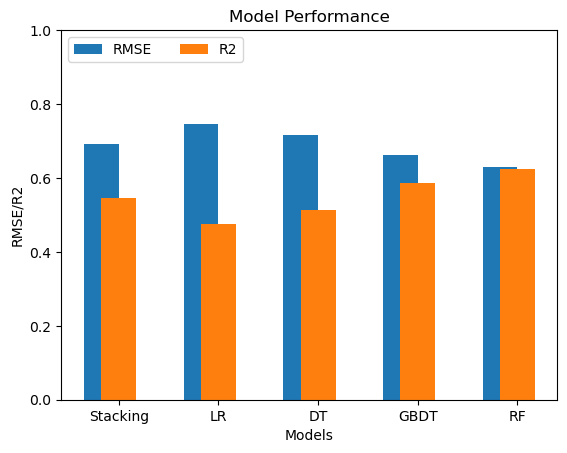

In [26]:
RMSE_Results = [stack_rmse, lr_rmse, dt_rmse, gbdt_rmse, rf_rmse]
R2_Results = [stack_r2, lr_r2, dt_r2, gbdt_r2, rf_r2]

rg= np.arange(5)
width = 0.35

# 1. Create bar plot with RMSE results
plt.bar(rg, RMSE_Results, width, label='RMSE')

# 2. Create bar plot with R2 results
plt.bar(rg + width/2, R2_Results, width, label='R2')


labels = ['Stacking','LR', 'DT', 'GBDT', 'RF']
plt.xticks(rg + width/2, labels)

plt.xlabel("Models")
plt.ylabel("RMSE/R2")


plt.ylim([0,1])
plt.title('Model Performance')
plt.legend(loc='upper left', ncol=2)
plt.show()


<b>Analysis</b>: Compare and contrast the resulting $R^2$ and RSME scores of the ensemble models and the individual models. Are the ensemble models performing better? Which is the best performing model? Explain.

The ensemble methods are performing better as seen in the graph by their lower RMSE and higher R2. Random forest seems to be the best performing model among these as it has the lowest RMSE and highest R2 score. 